#PUI 2015 - HW10
___
#Author: Arno Amabile

In [59]:
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns

import json
import zipfile 
import geopandas as gpd
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap



# I - Data preparation

In [ ]:
"""
$ for ((y=93; y<=99; y+=1)); do wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp$y\totals.zip; done
$ for ((y=0; y<=9; y+=1)); do wget ftp://ftp.census.gov/econ200$y\/CBP_CSV/zbp0$y\totals.zip; done
$ for ((y=10; y<=15; y+=1)); do wget ftp://ftp.census.gov/econ20$y\/CBP_CSV/zbp$y\totals.zip; done
"""

## 1. Data collection

In [2]:
zpb = {}

for i in range(94,100) + range(0,14):
    fname = 'zbp{}totals.zip'.format(str(i).zfill(2))
    zf = zipfile.ZipFile('../Data/' + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    
    df.columns = [c.lower() for c in df.columns] #To have same column name (zip/ZIP)
    df['zip'] = df['zip'].astype(str) #For subsequent merge
    zpb[str(i).zfill(2)] = df

In [3]:
nyc_zip = gpd.read_file('../Data/nyc-zip-code-tabulation-areas.geojson')

## 2. Data merging & subsetting

In [45]:
nyc_zpb = pd.DataFrame(columns=['zip'])
nyc_zpb['zip'] = nyc_zip['postalCode']

#Merge all years with only the est variable
for year, df in zpb.items():
    nyc_zpb = nyc_zpb.merge(df[['zip', 'est']], on='zip', how='left').rename(columns={'est': 'est_{}'.format(year)})

nyc_zpb.index = nyc_zpb['zip']
nyc_zpb = nyc_zpb.drop('zip',1).drop_duplicates()

In [46]:
a = nyc_zpb[nyc_zpb.isnull().any(axis=1) == True].shape[0]
print "Number of zipcodes with a missing year:", a

#I drop the zipcodes with at least one missing value
nyc_zpb_sub = nyc_zpb[nyc_zpb.isnull().any(axis=1) == False]
print "Sanity check: Nzipcodes = {0:}, Ntimestamps = {1:}".format(nyc_zpb_sub.shape[0], nyc_zpb_sub.shape[1])

Number of zipcodes with a missing year: 15
Sanity check: Nzipcodes = 230, Ntimestamps = 20


## 3. Data standardization

In [47]:
#Standardize variables
for col in nyc_zpb_sub.columns:
    nyc_zpb_sub[col] = (nyc_zpb_sub[col] - nyc_zpb_sub[col].mean())/(nyc_zpb_sub[col].std())

#Reorder variables for future plotting
cols= (['est_{}'.format(str(i).zfill(2)) for i in range(94,100)] + 
       ['est_{}'.format(str(i).zfill(2)) for i in range(0,14)])
nyc_zpb_sub = nyc_zpb_sub[cols]

/Users/ArnoAmabile/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


# II - Clustering
## 1. KMeans

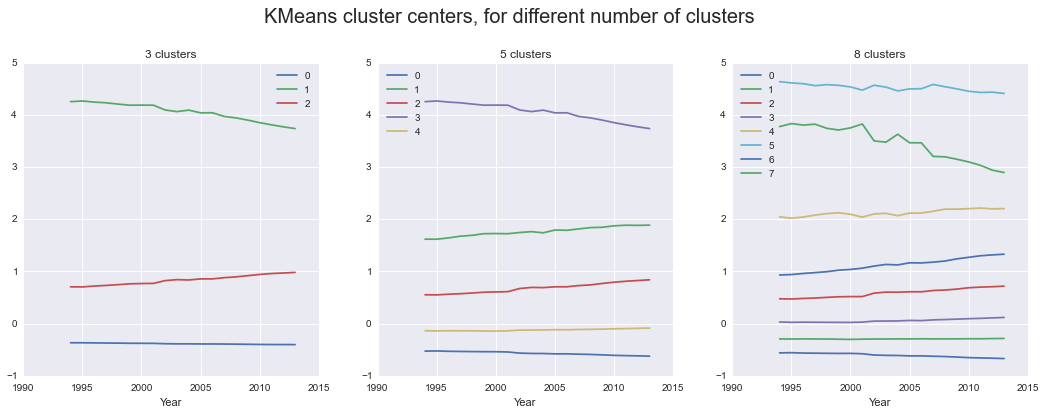

In [250]:
closest_centroids, cluster_centers = {}, {}
for nk in [3,5,8]:
    kmeans =  KMeans(nk).fit(nyc_zpb_sub)
    closest_centroids[str(nk)] = kmeans.predict(nyc_zpb_sub)
    cluster_centers[str(nk)] = kmeans.cluster_centers_

fig, axs = plt.subplots(1,3)
fig.set_size_inches(18, 6)
for i, nk in enumerate([3,5,8]):
    for j in range(nk):
        axs[i].plot(range(1994,2014), cluster_centers[str(nk)][j], label=j)
        axs[i].legend(loc=0)
        axs[i].set_title('{} clusters'.format(nk))
        axs[i].set_xlabel('Year')
        axs[i].set_ylabel('')
        
plt.suptitle('KMeans cluster centers, for different number of clusters', fontsize=20)
plt.subplots_adjust(top=0.85) 

In [256]:
np.unique(closest_centroids['3'], return_counts=True), np.unique(closest_centroids['5'], return_counts=True)

((array([0, 1, 2], dtype=int32), array([181,   9,  40])),
 (array([0, 1, 2, 3, 4], dtype=int32), array([106,   6,  33,   9,  76])))

## 2. Hierarchical Clustering
Some ideas for hierarchical clustering are inspired by https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/

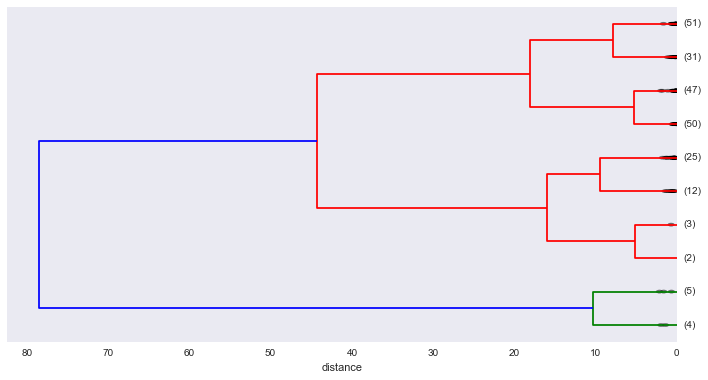

In [61]:
fig = plt.figure(figsize=(12,6))
plt.xlabel("distance")

hierarch = linkage(nyc_zpb_sub, method='ward')
ddg = dendrogram(hierarch, truncate_mode='lastp', show_contracted=True, p=10,
                               leaf_rotation=90., orientation='right', labels=nyc_zpb_sub.index)
#pl.xticks(rotation=90)
plt.grid('off')

In [252]:
zpb_clust = pd.DataFrame(nyc_zpb_sub.reset_index()['zip'])
zpb_clust['clusters_h'] = fcluster(hierarch,5, criterion='maxclust') - 1 #To have 0-4 as cluster number
zpb_clust['clusters_k'] = closest_centroids['5']

zpb_clust = gpd.GeoDataFrame(zpb_clust.merge(nyc_zip[['postalCode', 'geometry']], left_on='zip', right_on='postalCode'))

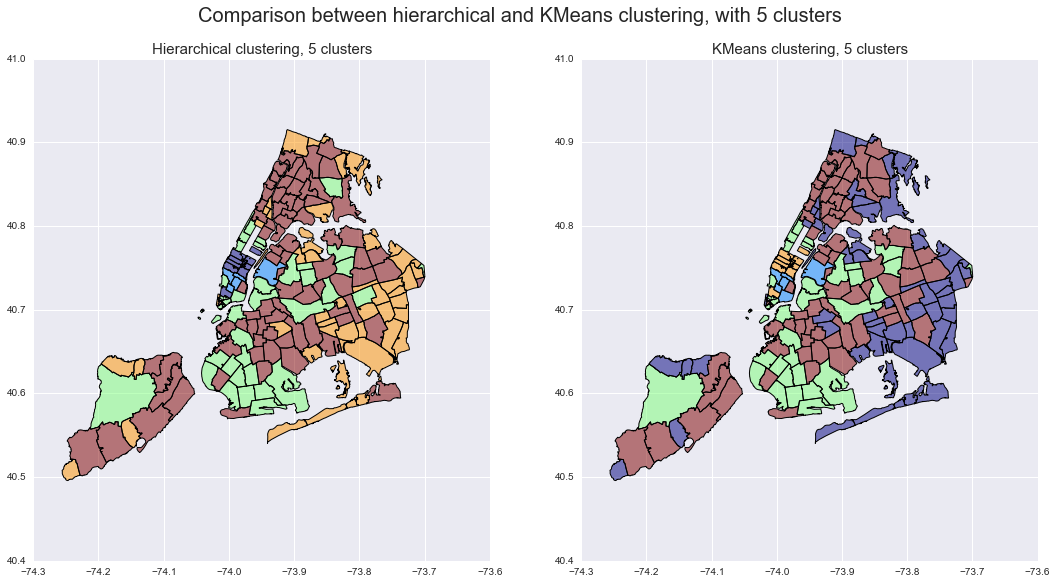

In [253]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(18,9)
zpb_clust.plot(column='clusters_h', cmap='jet', ax=axs[0])
axs[0].set_title('Hierarchical clustering, 5 clusters', fontsize=15)

zpb_clust.plot(column='clusters_k', cmap='jet', ax=axs[1])
axs[1].set_title('KMeans clustering, 5 clusters', fontsize=15)

plt.suptitle('Comparison between hierarchical and KMeans clustering, with 5 clusters', fontsize=20)

# III - Conclusion

**Comparison**

Interestingly enough, the results for the two algorithms do not differ substantially. The different clusters regroup:

* Harlem, most of the Bronx and Staten Island, East Brooklyn, and some parts of Queens (Maroon)
* East/West Village and Long Island City (Light blue)
* Midtown and lower Manhattan (Purple in hierarchical, Orange in KMeans) 
* Freshkills, South Brookly, Downtown Brooklyn, Williamsburg, Upper West Side, and some parts of Queens (Light green)

* The last cluster differs between the two algorithms (Orange in hierarchical, Purple in KMeans): 
    * With the hierarchical clustering, it only includes some peripheral parts of Staten Island and the Bronx, as weel as the eastern border of Queens and the Rockaways.
    * With the KMeans clustering, it includes some additional zipcodes in the Bronx, Harlem, and Brooklyn
    
    
**Interpretation**

* The cluster 3 in KMeans (Midtown, lower Manhattan & UES; Orange) is far above the mean in terms of number of businesses throughout the period.
* The zipcodes in cluster 2 (Downtown Brooklyn & Williamsburg; Green) have seen their number of businesses increase throughout the period, but stay close to the mean)
* Clusters 0 and 4 are the only ones below the mean, and not strikingly so. This means that, in terms of zipcodes which have a number of businesses below the mean, there does not seem to be a clear pattern in terms of parallell evolution.